# Initial Setup

In [1]:
import os
import shutil
import glob
from dotenv import load_dotenv

# Chunking documents
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter

# Building vector db using FAISS
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from huggingface_hub import login
from langchain_huggingface import HuggingFaceEmbeddings, ChatHuggingFace
from langchain.vectorstores import FAISS

# Visualizing vector db
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import TSNE

# Chunking the Knowledge Base

In [2]:
ABSOLUTE_PATH = os.path.abspath(os.getcwd())
KB_PATH = os.path.join(ABSOLUTE_PATH, "knowledge-base")
DB_PATH = os.path.join(ABSOLUTE_PATH, "VectorDBs", "nexatech_faiss_vector_db")
DB_HF_PATH = os.path.join(ABSOLUTE_PATH, "VectorDBs", "nexatech_faiss_vector_db_hf")

In [3]:
all_folders = glob.glob(KB_PATH + "/*")

loader_config = {"encoding": "utf-8"}
all_documents = []
for folder in all_folders:
    category_name = os.path.basename(folder)

    loader = DirectoryLoader(
        path=folder,
        glob="**/*.md",
        loader_cls=TextLoader,
        loader_kwargs=loader_config
    )

    documents = loader.load()
    
    for doc in documents:
        doc.metadata["doc_type"] = category_name
        all_documents.append(doc)

In [4]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(all_documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [5]:
def get_relevant_context(query: str) -> str:
    for chunk in chunks:
        if query in chunk.page_content:
            print(chunk)
        else:
            print("__________")

get_relevant_context("Lancaster")

page_content='# About Insurellm

Insurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. It's first product was Markellm, the marketplace connecting consumers with insurance providers.
It rapidly expanded, adding new products and clients, reaching 200 emmployees by 2024 with 12 offices across the US.' metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\company\\about.md', 'doc_type': 'company'}
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
__________
_______

# Building Vector Database

## Using OpenAIEmbeddings

In [6]:
load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "type-your-api-key-here")

db_name = DB_PATH
openai_embeddings = OpenAIEmbeddings()

In [7]:
# Check Chroma vectorstore in directory

if os.path.exists(DB_PATH):
    # print("FAISS vectorstore already exist. Load FAISS vectorstore.")
    # vectorstore = FAISS.load_local(DB_PATH, embeddings=openai_embeddings, allow_dangerous_deserialization=True)
    # total_vectors = vectorstore.index.ntotal
    # dimensions = vectorstore.index.d
    # print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in this FAISS vector store")
    
    # print("Delete collection from FAISS vectorstore")
    # vectorstore.index.reset()
    # vectorstore.docstore = {}
    # vectorstore.index_to_docstore_id = {}
    
    print("FAISS vectorstore already exist. Delete FAISS vectorstore from directory.")
    shutil.rmtree(DB_PATH)

FAISS vectorstore already exist. Delete FAISS vectorstore from directory.


In [8]:
# Create FAISS vectorstore need to install "pip install faiss-gpu" or "pip install faiss-cpu" for python>=3.10

vectorstore = FAISS.from_documents(
    documents=chunks,
    embedding=openai_embeddings
)

# Save FAISS vectorstore manually
vectorstore.save_local(DB_PATH)

total_vectors = vectorstore.index.ntotal
dimensions = vectorstore.index.d
print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in this FAISS vector store")

There are 123 vectors with 1,536 dimensions in this FAISS vector store


In [9]:
# Sampling a single vector inside the FAISS vectorstore

def sampling_vector(vectorstore: FAISS, vector_index: int) -> None:
    doc_id = vectorstore.index_to_docstore_id[vector_index]
    document = vectorstore.docstore.search(doc_id) # has page content and metadata
    print(f"Vector: \n{document}\n\n")
    
    sample_vector = vectorstore.index.reconstruct(vector_index)
    print(f"This vector has {len(sample_vector)} dimensions:\n{sample_vector[:25]}")

sampling_vector(vectorstore=vectorstore, vector_index=0)

Vector: 
page_content='# About Insurellm

Insurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. It's first product was Markellm, the marketplace connecting consumers with insurance providers.
It rapidly expanded, adding new products and clients, reaching 200 emmployees by 2024 with 12 offices across the US.' metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\company\\about.md', 'doc_type': 'company'}


This vector has 1536 dimensions:
[-0.01778596  0.00710626 -0.02663834 -0.02550134 -0.01418546  0.01701443
 -0.03216092 -0.00100249  0.016852   -0.00514697  0.01790779  0.00938704
 -0.00504206  0.00262086  0.01520064  0.0061926   0.01190468 -0.01204004
 -0.00183578 -0.00983372 -0.01111284 -0.0086155   0.01023979  0.01472689
 -0.00558688]


### Simple Retrieval Application using OpenAI Vectorstore

In [10]:
def retrieve_context(query: str, vectorstore: FAISS):
    context = vectorstore.similarity_search(query, k=5)
    return context

retrieve_context("products", vectorstore=vectorstore)

[Document(id='8bba12c5-a437-47c5-9164-7758c349bf91', metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\products\\Homellm.md', 'doc_type': 'products'}, page_content='With Homellm, Insurellm is committed to transforming the landscape of home insurance, ensuring both innovation and reliability for all insurance providers and their customers. Explore the future of home insurance today with Homellm!'),
 Document(id='65b3b769-5c58-4004-91ac-3df76bf5b546', metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\employees\\Emily Carter.md', 'doc_type': 'employees'}, page_content="Emily Carter exemplifies the kind of talent that drives Insurellm's success and is an invaluable asset to the company."),
 Document(id='7d2b7109-4073-411c-b20b-3fa2e252dae4', metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\products\\Homellm.md', 'doc_type': 'products'}, page_content="### 2. Dynamic Pricing Model\nWith Homellm's innovative dyn

## Using HuggingFaceEmbeddings

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [11]:
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN", "type-your-token-here")
login(HF_TOKEN)

db_name = DB_HF_PATH
hf_embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

In [12]:
# Check FAISS vectorstore for hugging face in directory

if os.path.exists(DB_HF_PATH):
    # print("FAISS vectorstore already exists. Load FAISS vectorstore.")
    # hf_vectorstore = FAISS.load_local(DB_HF_PATH, embeddings=hf_embeddings, allow_dangerous_deserialization=True)
    # total_vectors = hf_vectorstore.index.ntotal
    # dimensions = hf_vectorstore.index.d
    # print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in this FAISS vector store")

    # print("Delete collection from FAISS vectorstore")
    # vectorstore.index.reset()
    # vectorstore.docstore = {}
    # vectorstore.index_to_docstore_id = {}

    print("HF FAISS vectorstore already exists. Delete HF FAISS vectorstore.")
    shutil.rmtree(DB_HF_PATH)

HF FAISS vectorstore already exists. Delete HF FAISS vectorstore.


In [13]:
# Create FAISS vectorstore for hugging face

hf_vectorstore = FAISS.from_documents(
    documents=chunks,
    embedding=hf_embeddings
)

# Save to local
hf_vectorstore.save_local(DB_HF_PATH)

total_vectors = hf_vectorstore.index.ntotal
dimensions = hf_vectorstore.index.d
print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in this HF FAISS vector store")

There are 123 vectors with 384 dimensions in this HF FAISS vector store


In [14]:
# Sampling a single vector inside the FAISS vectorstore for hugging face

sampling_vector(vectorstore=hf_vectorstore, vector_index=0)

Vector: 
page_content='# About Insurellm

Insurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. It's first product was Markellm, the marketplace connecting consumers with insurance providers.
It rapidly expanded, adding new products and clients, reaching 200 emmployees by 2024 with 12 offices across the US.' metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\company\\about.md', 'doc_type': 'company'}


This vector has 384 dimensions:
[-0.04517025 -0.00403833 -0.04767371  0.05794198  0.00709063 -0.01202404
  0.11399041  0.03223649 -0.02385727 -0.02508519  0.07447963  0.02483185
  0.10526193 -0.02771228 -0.03795179  0.01815151 -0.0118475  -0.0432383
  0.03212366  0.02716946 -0.04610544 -0.00426115 -0.01155583 -0.00819234
 -0.03337602]


### Simple Retrieval Application using OpenAI Vectorstore

In [15]:
retrieve_context(query="products", vectorstore=hf_vectorstore)

[Document(id='c88c3477-6913-48ca-8594-5b14f7ef02c4', metadata={'source': 'D:\\Learn\\LLM\\llm_engineering\\week5\\knowledge-base\\employees\\Emily Carter.md', 'doc_type': 'employees'}, page_content='- **2017-2019:** Marketing Intern  \n  - Assisted with market research and campaign development for social media outreach.  \n  - Achievements:  \n    - Contributed ideas for a social media campaign that increased brand awareness by 40% within 6 months.  \n\n## Annual Performance History\n| Year | Performance Rating | Key Highlights |\n|------|--------------------|----------------|\n| 2023 | 4.8/5              | Recognized for exceptional client feedback and teamwork during product launches. |\n| 2022 | 4.5/5              | Led a successful cross-selling initiative that boosted revenue in existing accounts. |\n| 2021 | 4.2/5              | Successfully onboarded new clients and established strong relationships that resulted in renewals. |'),
 Document(id='e81f3794-a6ec-484d-b364-c01e1cec95b

# Visualizing FAISS Vector Stores

## OpenAIEmbeddings

In [16]:
# Prework
vectors = []
documents = []
doc_types = []
colors = []
color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

for i in range(total_vectors):
    vectors.append(vectorstore.index.reconstruct(i))
    doc_id = vectorstore.index_to_docstore_id[i]
    document = vectorstore.docstore.search(doc_id)
    documents.append(document.page_content)
    doc_type = document.metadata['doc_type']
    doc_types.append(doc_type)
    colors.append(color_map[doc_type])
    
vectors = np.array(vectors)

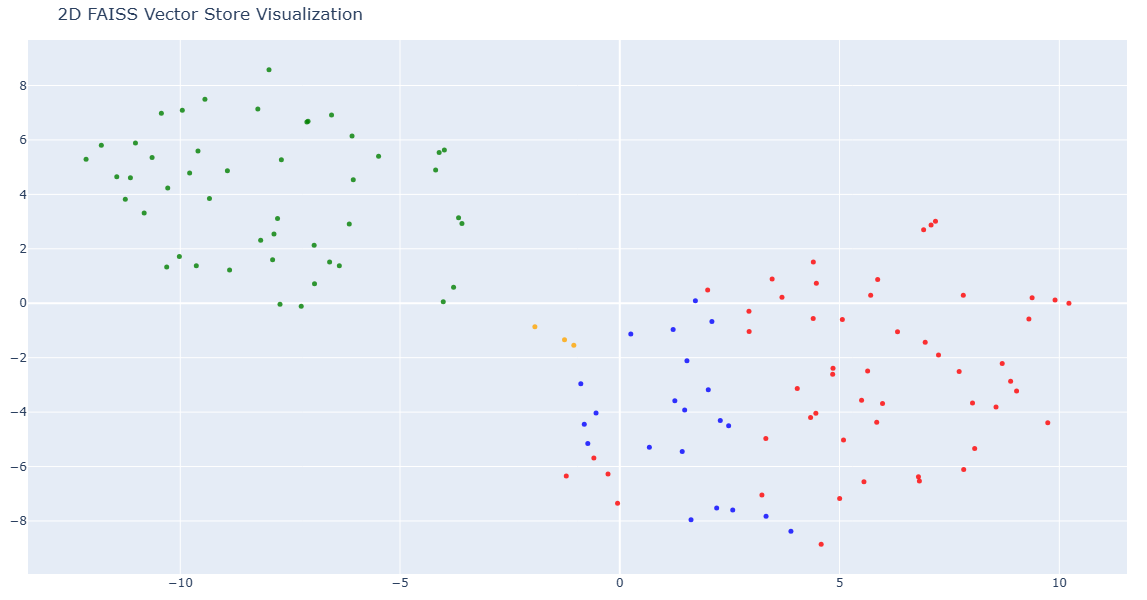

In [18]:
# Reduce the dimensionality of the vectors to 2D using t-SNE (t-distributed stochastic neighbor embedding)

try:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    # for small data documents
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

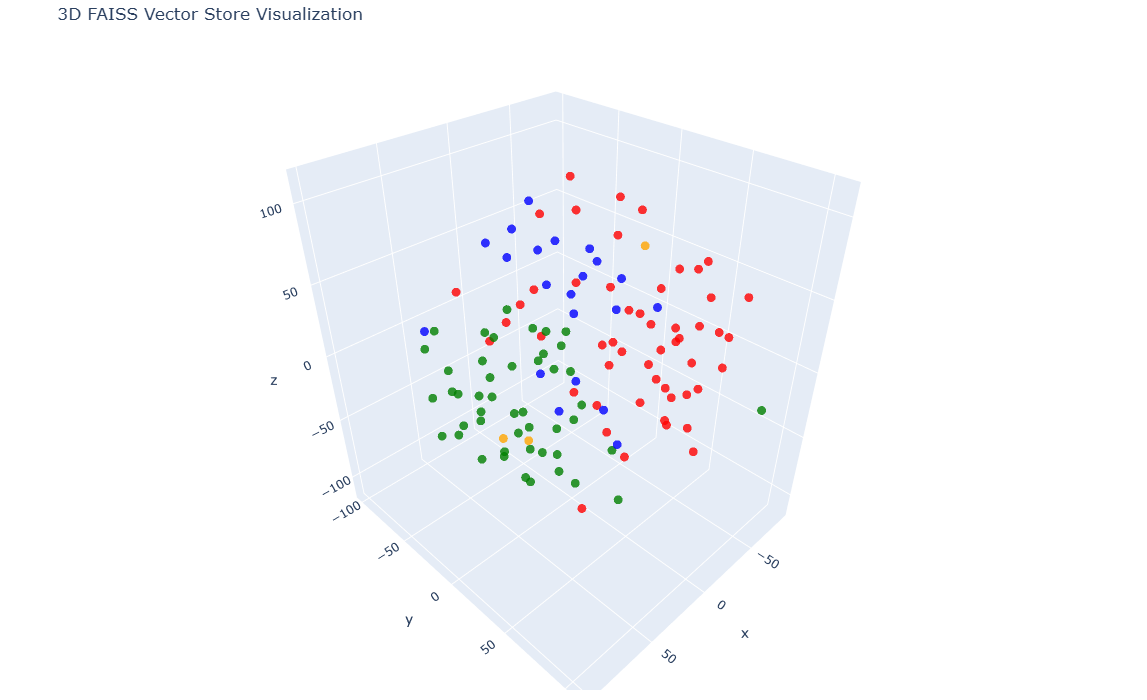

In [19]:
# 3D Visualization

try:
    tsne = TSNE(n_components=3, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    tsne = TSNE(n_components=3, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## HuggingFaceEmbeddings

In [20]:
# Prework
vectors = []
documents = []
doc_types = []
colors = []
color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

for i in range(total_vectors):
    vectors.append(hf_vectorstore.index.reconstruct(i))
    doc_id = hf_vectorstore.index_to_docstore_id[i]
    document = hf_vectorstore.docstore.search(doc_id)
    documents.append(document.page_content)
    doc_type = document.metadata['doc_type']
    doc_types.append(doc_type)
    colors.append(color_map[doc_type])
    
vectors = np.array(vectors)

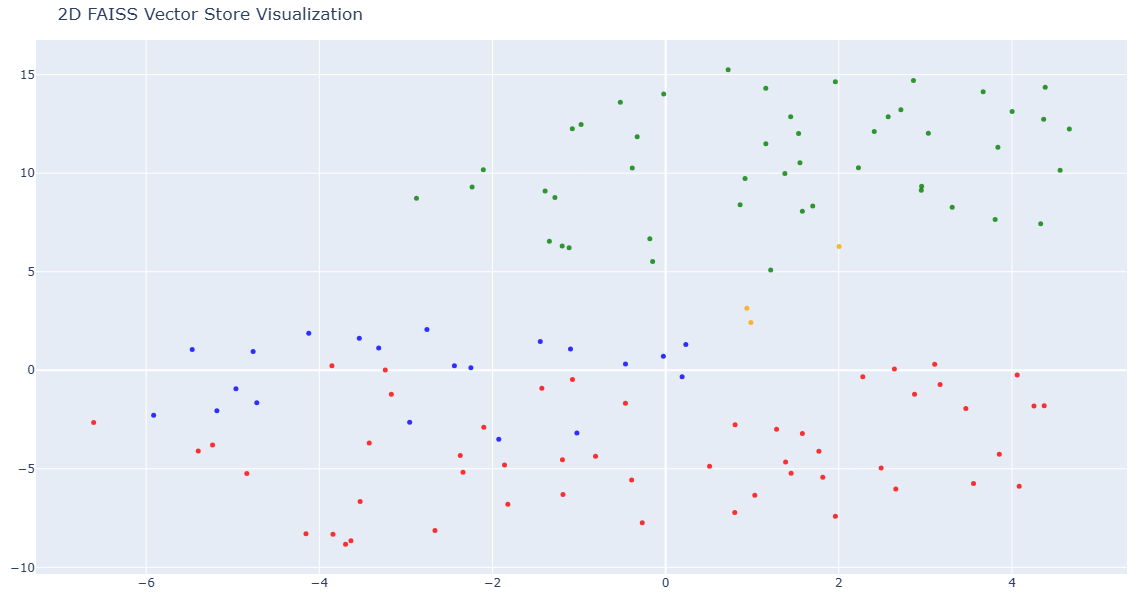

In [21]:
# Reduce the dimensionality of the vectors to 2D using t-SNE (t-distributed stochastic neighbor embedding)

try:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    # for small data documents
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

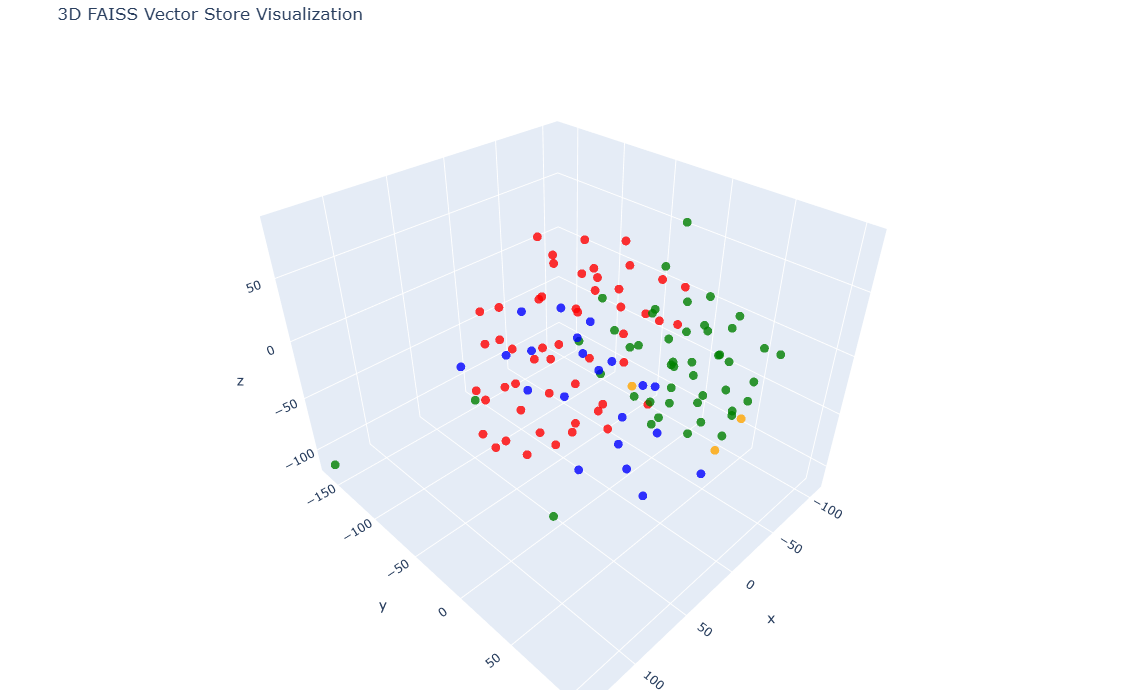

In [22]:
# 3D Visualization

try:
    tsne = TSNE(n_components=3, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
except:
    tsne = TSNE(n_components=3, random_state=42, perplexity=10)
    reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()